# Tracking Control Log Visualization 

In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [2]:
WHEEL_RADIUS = 0.875  # m

In [3]:
df = pd.read_csv(
    "tracking_control_node.csv",
    index_col=0,
    parse_dates=["timestamp"],
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3485 entries, 0 to 3484
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   steer_degree_fl             3485 non-null   float64       
 1   v_fl                        3485 non-null   float64       
 2   steer_degree_fr             3485 non-null   float64       
 3   v_fr                        3485 non-null   float64       
 4   steer_degree_rl             3485 non-null   float64       
 5   v_rl                        3485 non-null   float64       
 6   steer_degree_rr             3485 non-null   float64       
 7   v_rr                        3485 non-null   float64       
 8   steer_angle_fs              3485 non-null   float64       
 9   steer_angle_rs              3485 non-null   float64       
 10  v_fs                        3485 non-null   float64       
 11  v_rs                        3485 non-null   float64       
 1

## Log Timestamps

In [4]:
df["timestamp"].min(), df["timestamp"].max()

(Timestamp('2024-10-21 11:58:06.100057125'),
 Timestamp('2024-10-21 12:01:02.719528437'))

## Valid Flag

<Axes: xlabel='timestamp'>

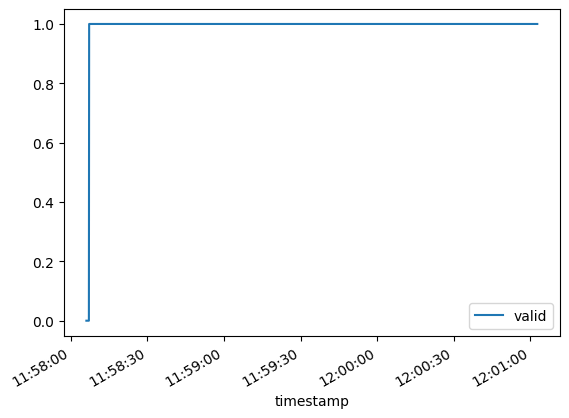

In [5]:
df.plot(x="timestamp", y="valid")

## Brake State Before Filtering

<Axes: xlabel='timestamp'>

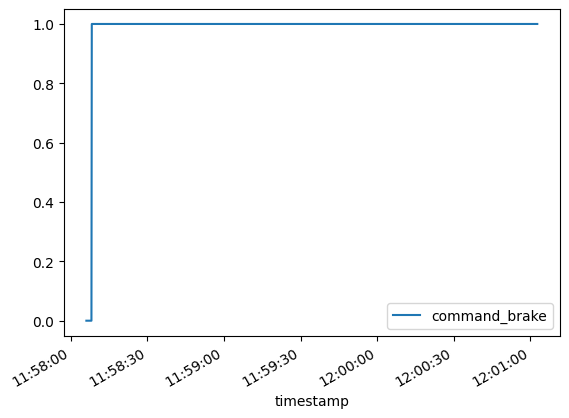

In [6]:
df.plot(x="timestamp", y="command_brake")

## Filter Out Invalid Data

In [7]:
df = df[df["valid"] == 1]
# zone_offset = pd.Timedelta(8, "h")
# begin_time = pd.Timestamp(1728465234, unit="s") + zone_offset
# end_time = pd.Timestamp(1728466138, unit="s") + zone_offset
# print(begin_time)
# print(end_time)
# df = df[
#     # (df["timestamp"] >= begin_time)
#     # &
#     (df["timestamp"] <= end_time)
# ]
print("remained records", len(df))

remained records 3465


## Localization (Vehicle Center)

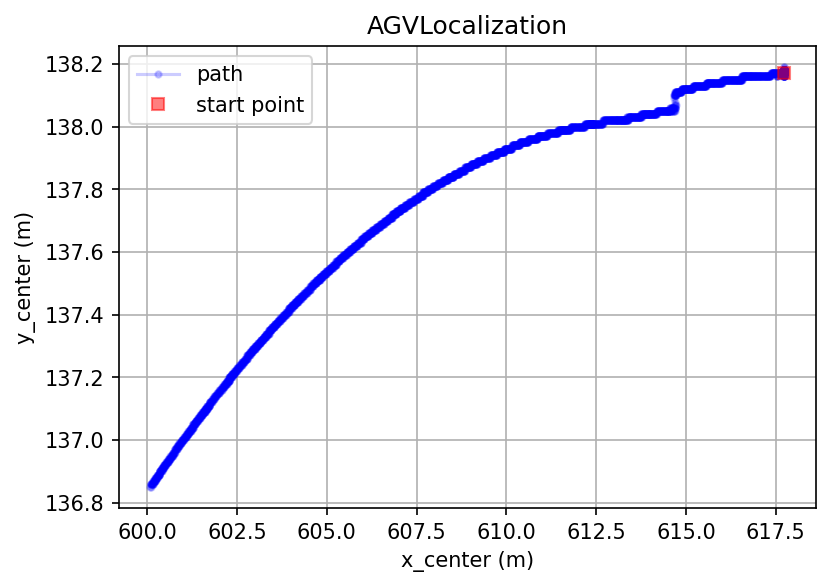

In [8]:
fig = plt.figure(figsize=(6, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

mask = (df["x_center"] != 0) & (df["y_center"] != 0)
ax.plot(
    df["x_center"].loc[mask],
    df["y_center"].loc[mask],
    "b.-",
    alpha=0.2,
    label="path",
)
ax.plot(
    df["x_center"].loc[mask].iloc[0],
    df["y_center"].loc[mask].iloc[0],
    "rs",
    alpha=0.5,
    label="start point",
)
ax.set(
    title="AGVLocalization",
    xlabel="x_center (m)",
    ylabel="y_center (m)",
    # ylim=(119, 119.5),
)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.legend()
ax.grid()

pass

## Localization (Antenna Centers)

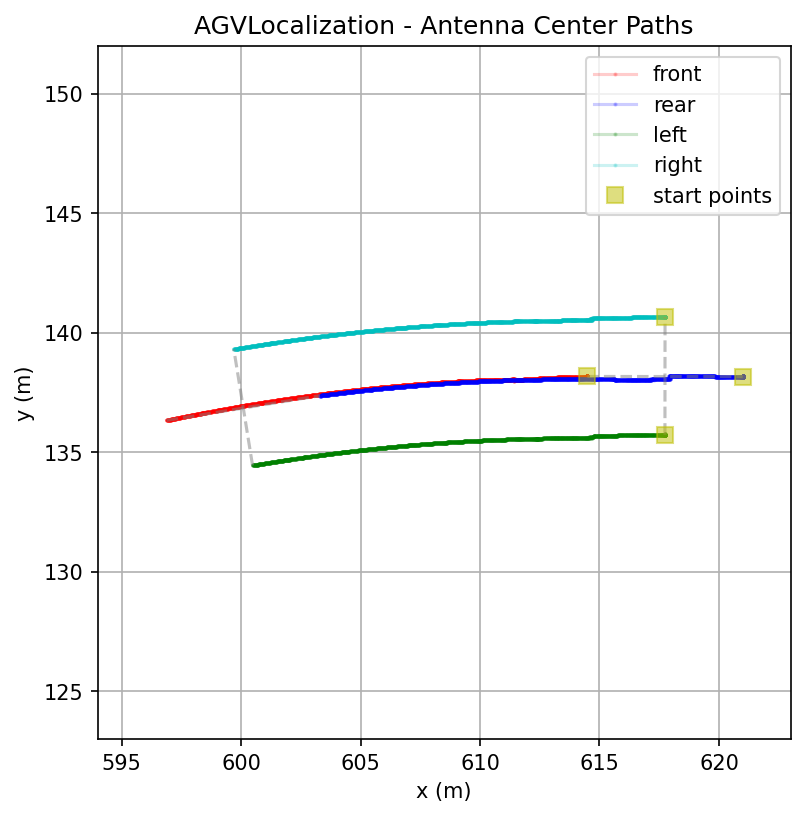

In [9]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["x_front"], df["y_front"], "r.-", ms=2, alpha=0.2, label="front")
ax.plot(df["x_rear"], df["y_rear"], "b.-", ms=2, alpha=0.2, label="rear")
ax.plot(df["x_left"], df["y_left"], "g.-", ms=2, alpha=0.2, label="left")
ax.plot(df["x_right"], df["y_right"], "c.-", ms=2, alpha=0.2, label="right")

# start/stop direction
for i in (0, -1):
    ax.plot(
        (df["x_front"].dropna().iloc[i], df["x_rear"].dropna().iloc[i]),
        (df["y_front"].dropna().iloc[i], df["y_rear"].dropna().iloc[i]),
        "--",
        color="gray",
        alpha=0.5,
    )
    ax.plot(
        (df["x_left"].dropna().iloc[i], df["x_right"].dropna().iloc[i]),
        (df["y_left"].dropna().iloc[i], df["y_right"].dropna().iloc[i]),
        "--",
        color="gray",
        alpha=0.5,
    )

# start points
ax.plot(
    *zip(
        *[
            (
                df[f"x_{suffix}"].dropna().iloc[0],
                df[f"y_{suffix}"].dropna().iloc[0],
            )
            for suffix in ("front", "rear", "left", "right")
        ]
    ),
    "ys",
    ms=8,
    alpha=0.5,
    label=f"start points",
)

x_front_max = df["x_front"].max()
x_front_min = df["x_front"].min()
y_front_max = df["y_front"].max()
y_front_min = df["y_front"].min()
x_rear_max = df["x_rear"].max()
x_rear_min = df["x_rear"].min()
y_rear_max = df["y_rear"].max()
y_rear_min = df["y_rear"].min()
x_max = max(x_front_max, x_rear_max)
x_min = min(x_front_min, x_rear_min)
y_max = max(y_front_max, y_rear_max)
y_min = min(y_front_min, y_rear_min)
x_mid = (x_max + x_min) / 2
y_mid = (y_max + y_min) / 2
view_radius = max(x_max - x_min, y_max - y_min) / 2 + 2

ax.set(
    title="AGVLocalization - Antenna Center Paths",
    xlabel="x (m)",
    ylabel="y (m)",
    xlim=(np.floor(x_mid - view_radius), np.ceil(x_mid + view_radius)),
    ylim=(np.floor(y_mid - view_radius), np.ceil(y_mid + view_radius)),
)
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.set_aspect("equal")
ax.legend()
ax.grid()

pass

## Localization (TransInAgv)

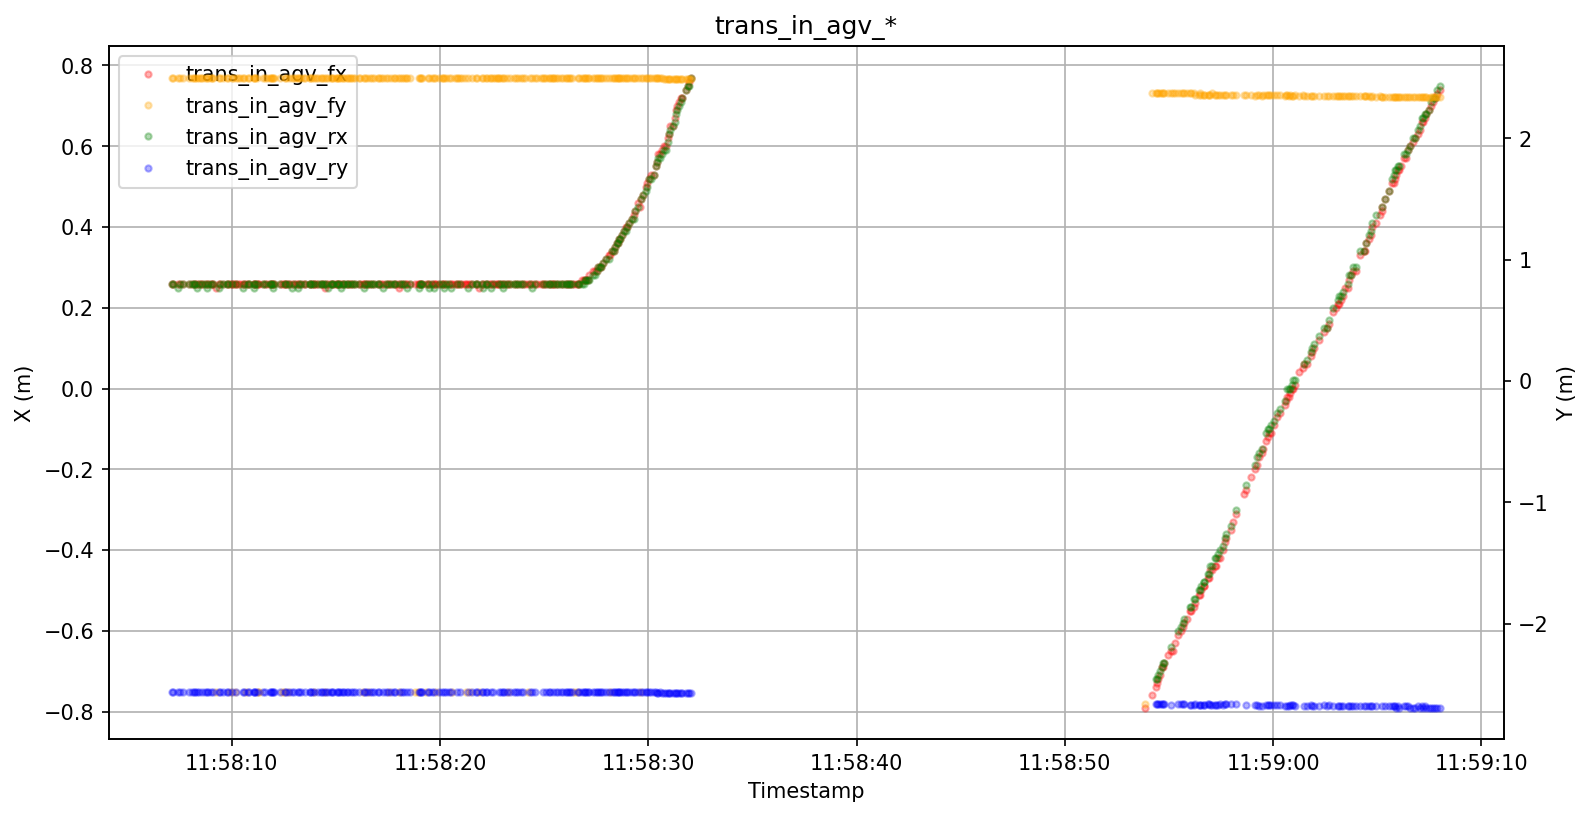

In [10]:
fig = plt.figure(figsize=(12, 6), dpi=150)
fig.set_facecolor("#fff")
ax_x = fig.add_subplot()
ax_y = ax_x.twinx()

handles = []

for label, color in (
    ("trans_in_agv_fx", "red"),
    ("trans_in_agv_fy", "orange"),
    ("trans_in_agv_rx", "green"),
    ("trans_in_agv_ry", "blue"),
):
    ax = ax_x if label[-1] == "x" else ax_y
    handle = ax.plot(
        df["timestamp"],
        df[label],
        "o",
        ms=3,
        color=color,
        alpha=0.3,
        label=label,
    )[0]
    handles.append(handle)

ax_x.set(
    title="trans_in_agv_*",
    xlabel="Timestamp",
    ylabel="X (m)",
)
ax_y.set_ylabel("Y (m)")
ax_x.legend(handles=handles)
ax_x.grid()

pass

## Front Antenna Center

Travelled X: nan
Travelled Y: nan


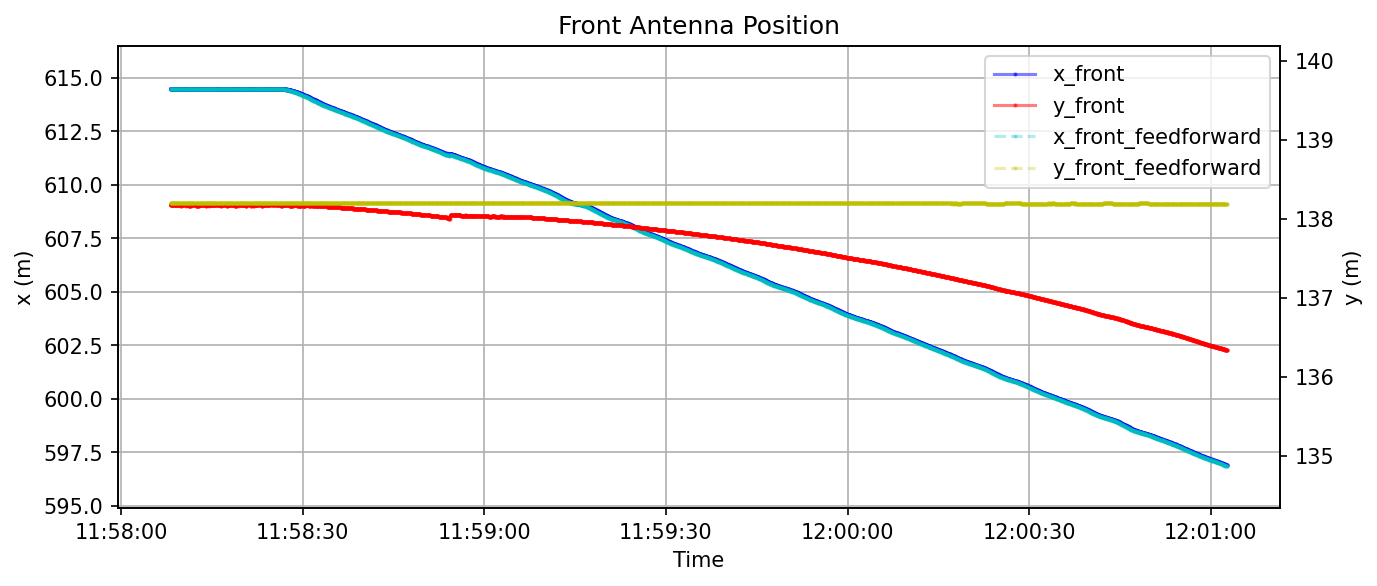

In [11]:
fig = plt.figure(figsize=(10, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax_twin = ax.twinx()

line_1 = ax.plot(
    df["timestamp"],
    df["x_front"],
    "b.-",
    ms=2,
    alpha=0.5,
    label="x_front",
)[0]
line_2 = ax_twin.plot(
    df["timestamp"],
    df["y_front"],
    "r.-",
    ms=2,
    alpha=0.5,
    label="y_front",
)[0]
line_3 = ax.plot(
    df["timestamp"],
    df["x_front_feedforward"],
    "c.--",
    ms=2,
    alpha=0.3,
    label="x_front_feedforward",
)[0]
line_4 = ax_twin.plot(
    df["timestamp"],
    df["y_front_feedforward"],
    "y.--",
    ms=2,
    alpha=0.3,
    label="y_front_feedforward",
)[0]
ax.set(
    title="Front Antenna Position",
    xlabel="Time",
    ylabel="x (m)",
    ylim=(df["x_front"].min() - 2, df["x_front"].max() + 2),
)
ax_twin.set(
    ylabel="y (m)",
    ylim=(df["y_front"].min() - 2, df["y_front"].max() + 2),
)
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax_twin.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.legend(handles=(line_1, line_2, line_3, line_4))
ax.grid()

print("Travelled X:", df["x_front"].iloc[-1] - df["x_front"].iloc[0])
print("Travelled Y:", df["y_front"].iloc[-1] - df["y_front"].iloc[0])

pass

## Rear Antenna Center

Travelled X: nan
Travelled Y: nan


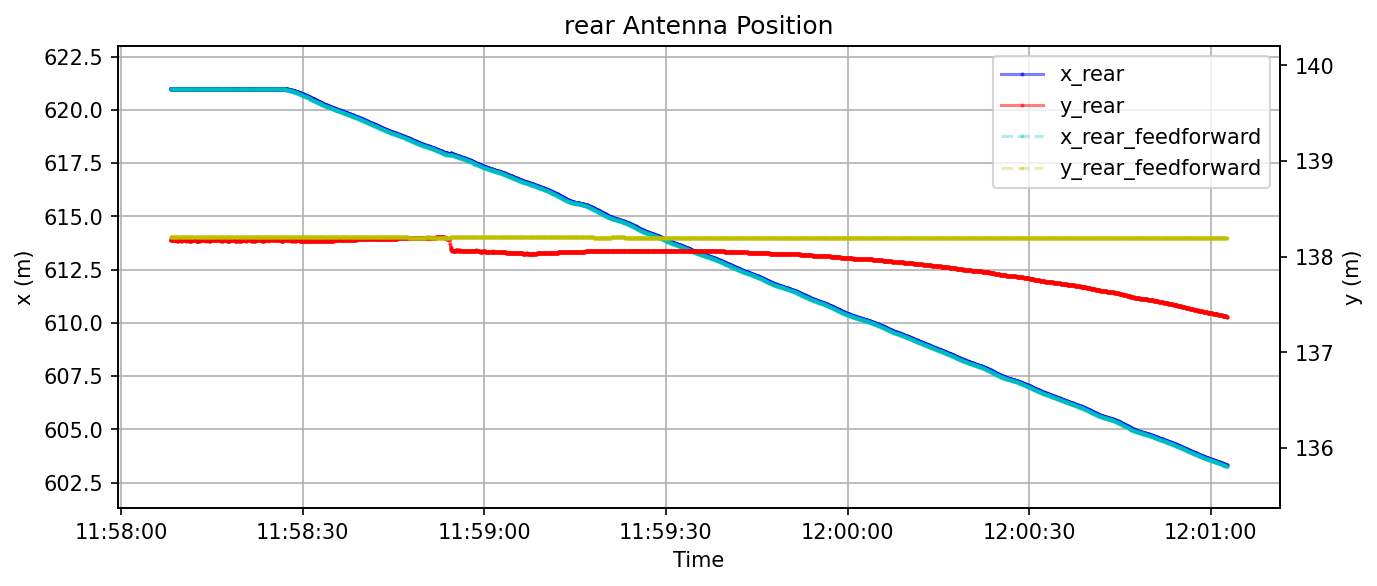

In [12]:
fig = plt.figure(figsize=(10, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax_twin = ax.twinx()

line_1 = ax.plot(
    df["timestamp"],
    df["x_rear"],
    "b.-",
    ms=2,
    alpha=0.5,
    label="x_rear",
)[0]
line_2 = ax_twin.plot(
    df["timestamp"],
    df["y_rear"],
    "r.-",
    ms=2,
    alpha=0.5,
    label="y_rear",
)[0]
line_3 = ax.plot(
    df["timestamp"],
    df["x_rear_feedforward"],
    "c.--",
    ms=2,
    alpha=0.3,
    label="x_rear_feedforward",
)[0]
line_4 = ax_twin.plot(
    df["timestamp"],
    df["y_rear_feedforward"],
    "y.--",
    ms=2,
    alpha=0.3,
    label="y_rear_feedforward",
)[0]
ax.set(
    title="rear Antenna Position",
    xlabel="Time",
    ylabel="x (m)",
    ylim=(df["x_rear"].min() - 2, df["x_rear"].max() + 2),
)
ax_twin.set(
    ylabel="y (m)",
    ylim=(df["y_rear"].min() - 2, df["y_rear"].max() + 2),
)
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax_twin.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.legend(handles=(line_1, line_2, line_3, line_4))
ax.grid()

print("Travelled X:", df["x_rear"].iloc[-1] - df["x_rear"].iloc[0])
print("Travelled Y:", df["y_rear"].iloc[-1] - df["y_rear"].iloc[0])

pass

## Vehicle Heading

### Final Heading

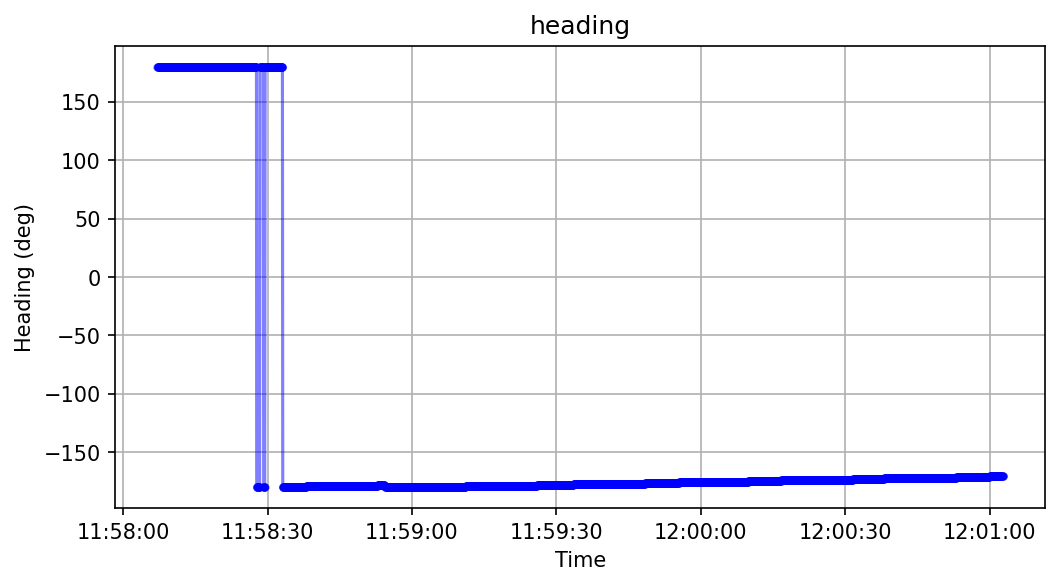

In [13]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["timestamp"], df["heading"] / pi * 180, "b.-", alpha=0.5)
ax.set(
    title="heading",
    xlabel="Time",
    ylabel="Heading (deg)",
)
ax.grid()

pass

### Heading Computed from One Antenna

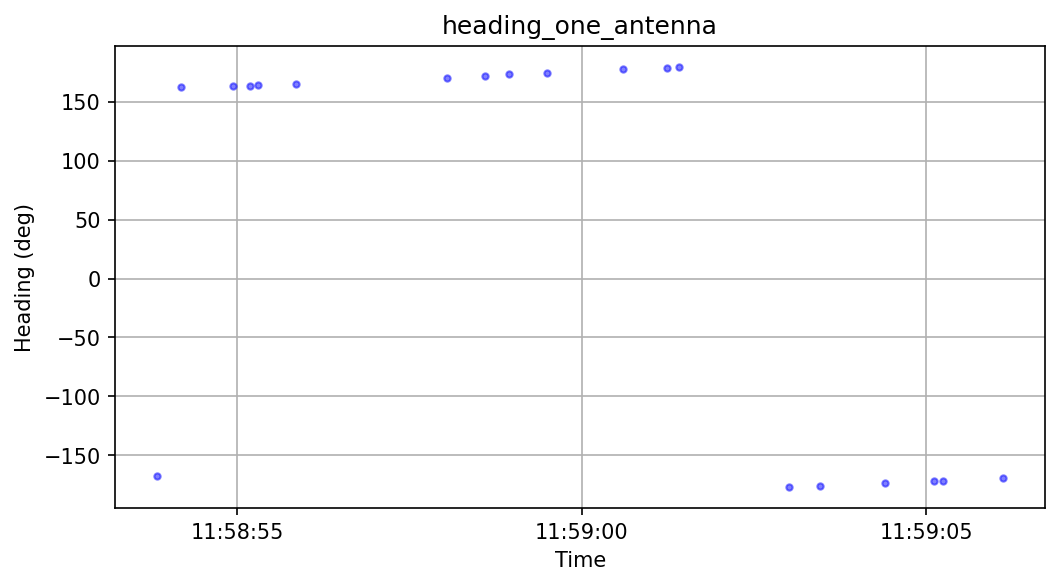

In [14]:
if "heading_one_antenna" in df.columns:

    fig = plt.figure(figsize=(8, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()

    mask = df["heading_one_antenna"] != 0
    ax.plot(
        df["timestamp"][mask],
        df["heading_one_antenna"][mask] / pi * 180,
        "b.",
        alpha=0.5,
    )
    ax.set(
        title="heading_one_antenna",
        xlabel="Time",
        ylabel="Heading (deg)",
    )
    ax.grid()

    pass

### Heading Computed from Two Antennas

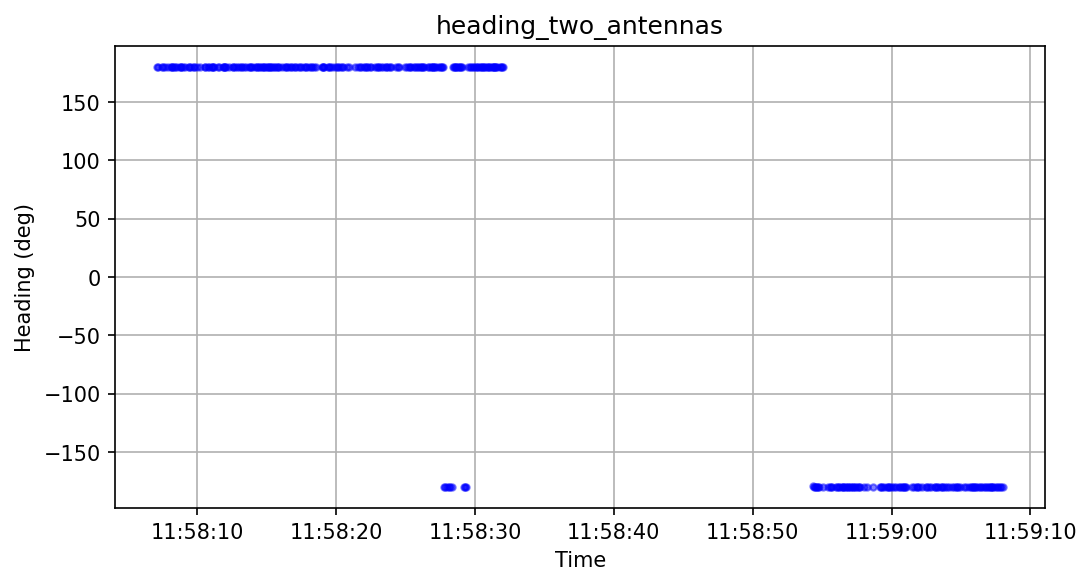

In [15]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

mask = df["heading_two_antennas"] != 0
ax.plot(
    df["timestamp"][mask],
    df["heading_two_antennas"][mask] / pi * 180,
    "b.",
    alpha=0.5,
)
ax.set(
    title="heading_two_antennas",
    xlabel="Time",
    ylabel="Heading (deg)",
)
ax.grid()

pass

## Running State

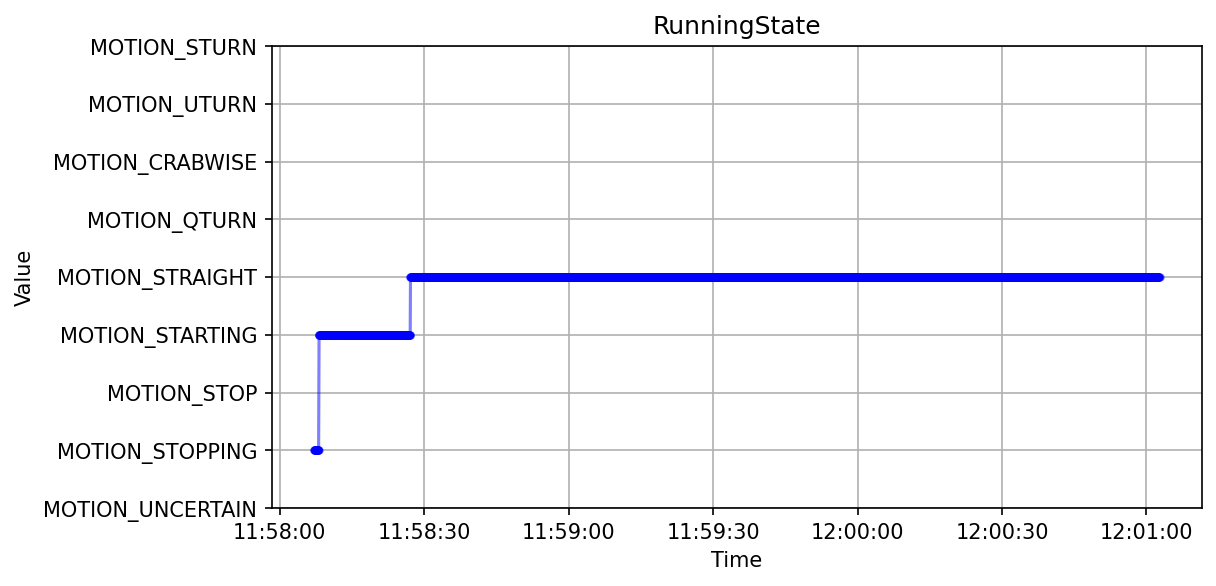

In [16]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["timestamp"], df["running_state"], "b.-", alpha=0.5)
ax.set(
    title="RunningState",
    xlabel="Time",
    ylabel="Value",
    yticks=list(range(-1, 7 + 1)),
    yticklabels=(
        "MOTION_UNCERTAIN",
        "MOTION_STOPPING",
        "MOTION_STOP",
        "MOTION_STARTING",
        "MOTION_STRAIGHT",
        "MOTION_QTURN",
        "MOTION_CRABWISE",
        "MOTION_UTURN",
        "MOTION_STURN",
    ),
)
ax.grid()

pass

## Provided Values

### Rel X/Y

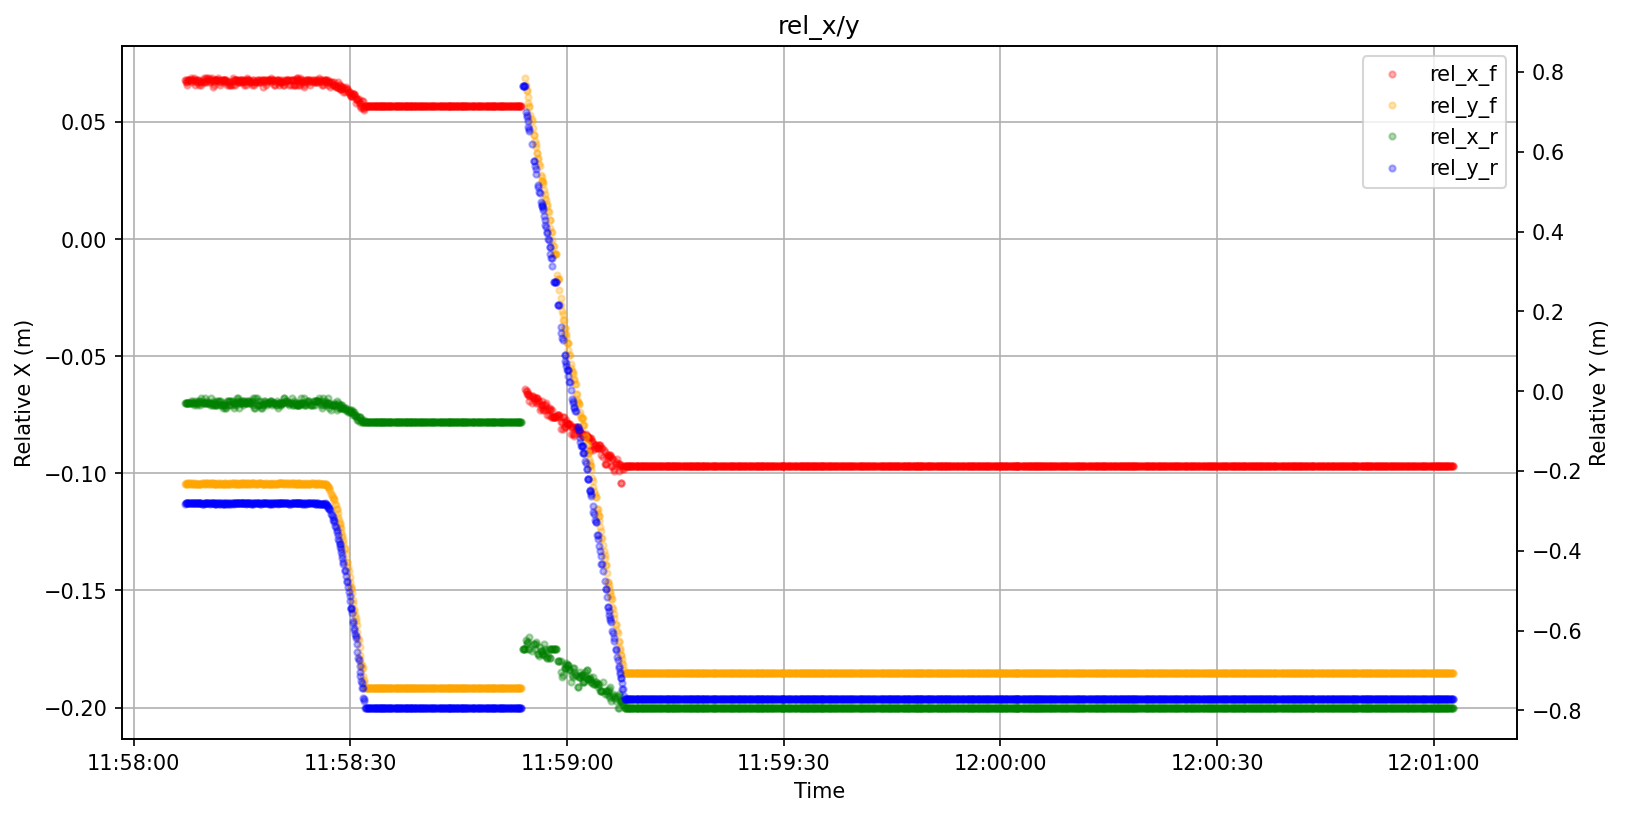

In [17]:
fig = plt.figure(figsize=(12, 6), dpi=150)
fig.set_facecolor("#fff")
ax_x = fig.add_subplot()
ax_y = ax_x.twinx()

handles = []

for label, color in (
    ("rel_x_f", "red"),
    ("rel_y_f", "orange"),
    ("rel_x_r", "green"),
    ("rel_y_r", "blue"),
):
    mask = (df["new_valid_data_arrived_" + label[-1]] == 1) & (
        df["trans_data_get_" + label[-1]] == 1
    )
    ax = ax_x if label[4] == "x" else ax_y
    handle = ax.plot(
        df["timestamp"].loc[mask],
        df[label].loc[mask] / 1000,
        "o",
        ms=3,
        color=color,
        alpha=0.3,
        label=label,
    )[0]
    handles.append(handle)

ax_x.set(
    title="rel_x/y",
    xlabel="Time",
    ylabel="Relative X (m)",
)
ax_y.set_ylabel("Relative Y (m)")
ax_x.legend(handles=handles)
ax_x.grid()

pass

### Omega

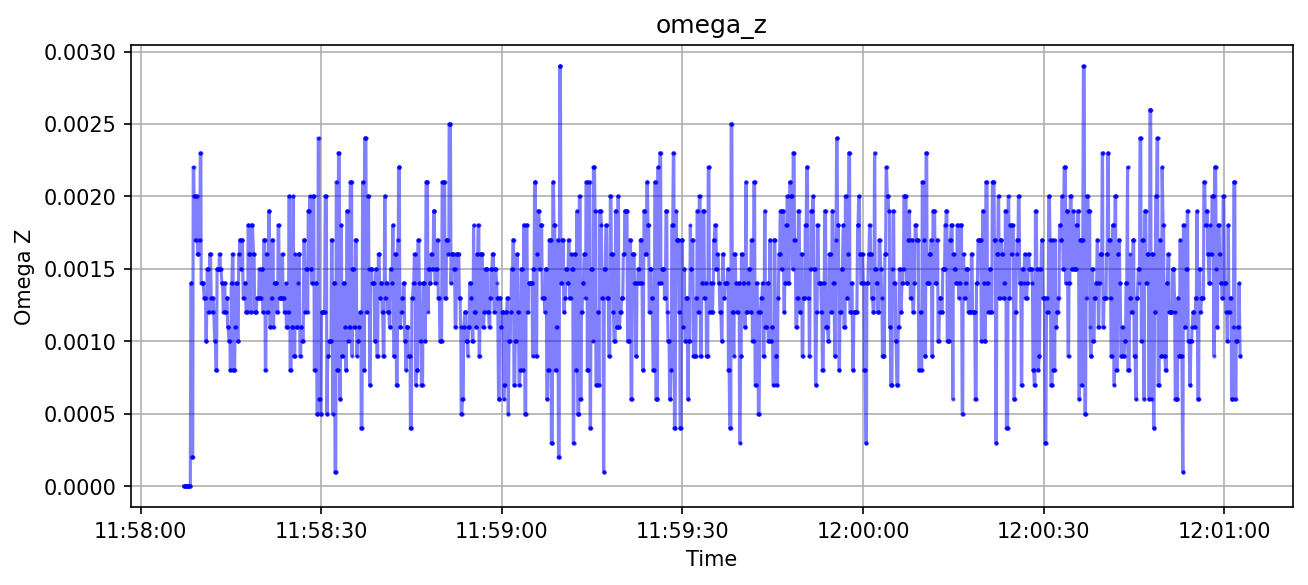

In [18]:
fig = plt.figure(figsize=(10, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["timestamp"], df["omega_z"], "b.-", ms=2, alpha=0.5)
ax.set(
    title="omega_z",
    xlabel="Time",
    ylabel="Omega Z",
)
ax.grid()

pass

### Provided Steer Angles

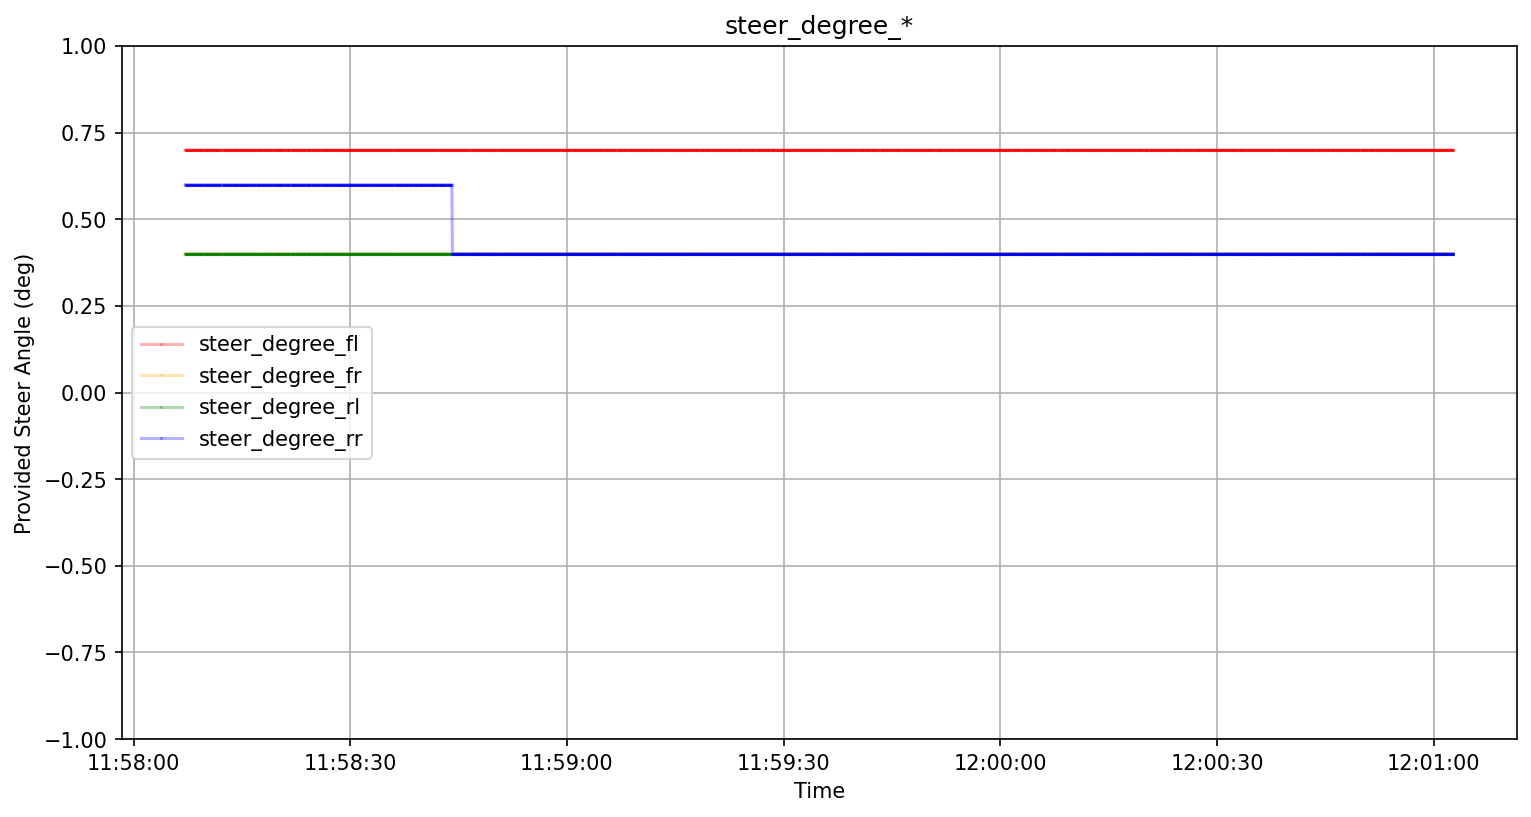

In [19]:
fig = plt.figure(figsize=(12, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

y_min = np.inf
y_max = -np.inf

for label, color in (
    ("steer_degree_fl", "red"),
    ("steer_degree_fr", "orange"),
    ("steer_degree_rl", "green"),
    ("steer_degree_rr", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        ms=1,
        color=color,
        alpha=0.3,
        label=label,
    )
    v_min = df[label].min()
    v_max = df[label].max()
    if v_min < y_min:
        y_min = v_min
    if v_max > y_max:
        y_max = v_max

Y_STEP = 1
y_min = (y_min // Y_STEP) * Y_STEP
y_max = (y_max // Y_STEP) * Y_STEP
y_limits = (
    y_min - Y_STEP,
    y_max + Y_STEP,
)

ax.set(
    title="steer_degree_*",
    xlabel="Time",
    ylabel="Provided Steer Angle (deg)",
    # yticks=np.arange(
    #     y_limits[0],
    #     y_limits[1] + Y_STEP,
    #     Y_STEP,
    # ),
    ylim=y_limits,
)
ax.legend(loc="center left")
ax.grid()

pass

### Provided Syn. Steer Degree

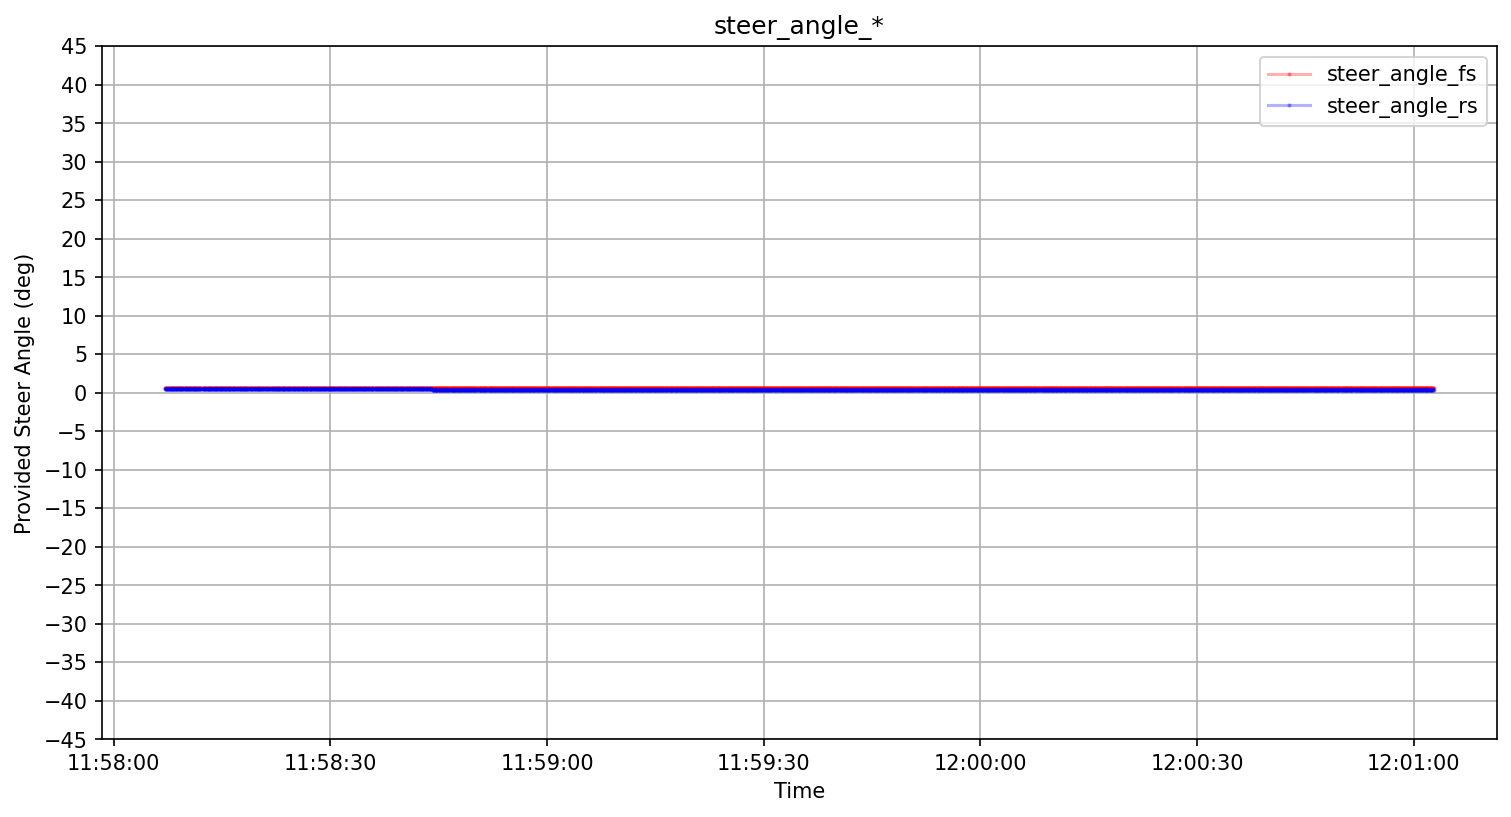

In [20]:
fig = plt.figure(figsize=(12, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("steer_angle_fs", "red"),
    ("steer_angle_rs", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label] * 180 / pi,
        ".-",
        color=color,
        ms=2,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="steer_angle_*",
    xlabel="Time",
    ylabel="Provided Steer Angle (deg)",
    ylim=(-45, 45),
    yticks=np.arange(-45, 45 + 1, 5),
)
ax.legend()
ax.grid()

pass

### Provided Velocity

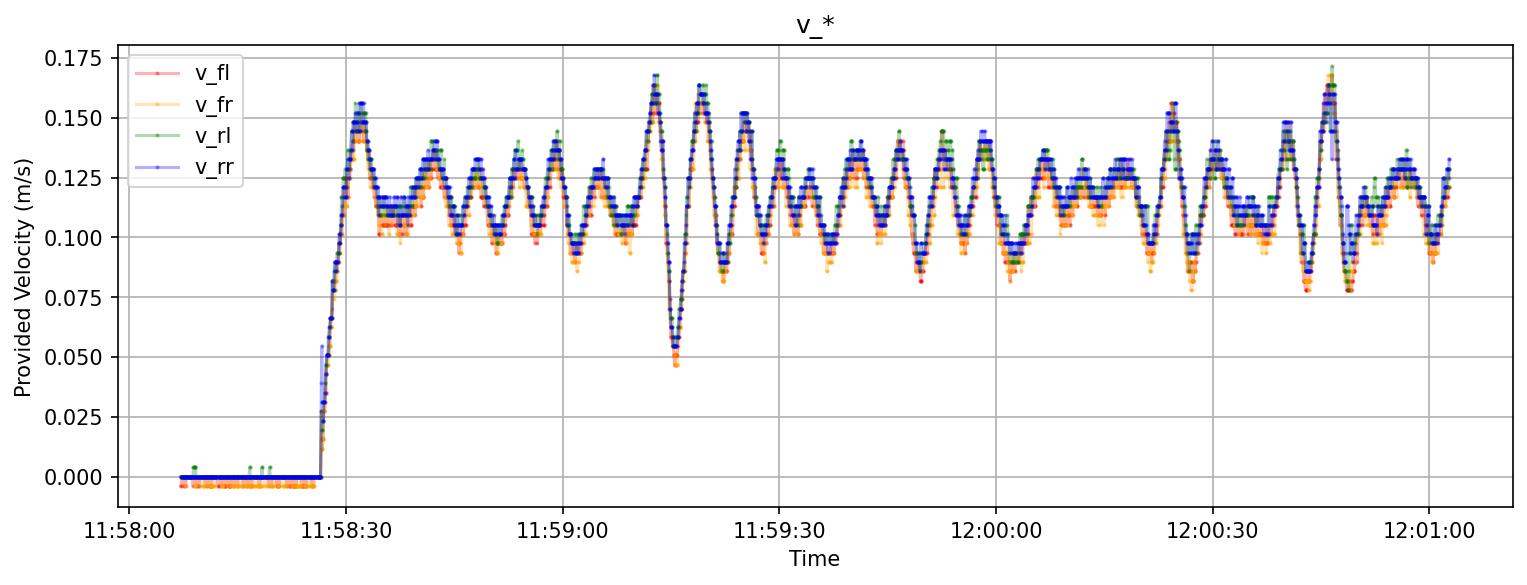

In [21]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("v_fl", "red"),
    ("v_fr", "orange"),
    ("v_rl", "green"),
    ("v_rr", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        ms=2,
        color=color,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="v_*",
    xlabel="Time",
    ylabel="Provided Velocity (m/s)",
)
ax.legend(loc="upper left")
ax.grid()

pass

### Provided Syn. Velocity

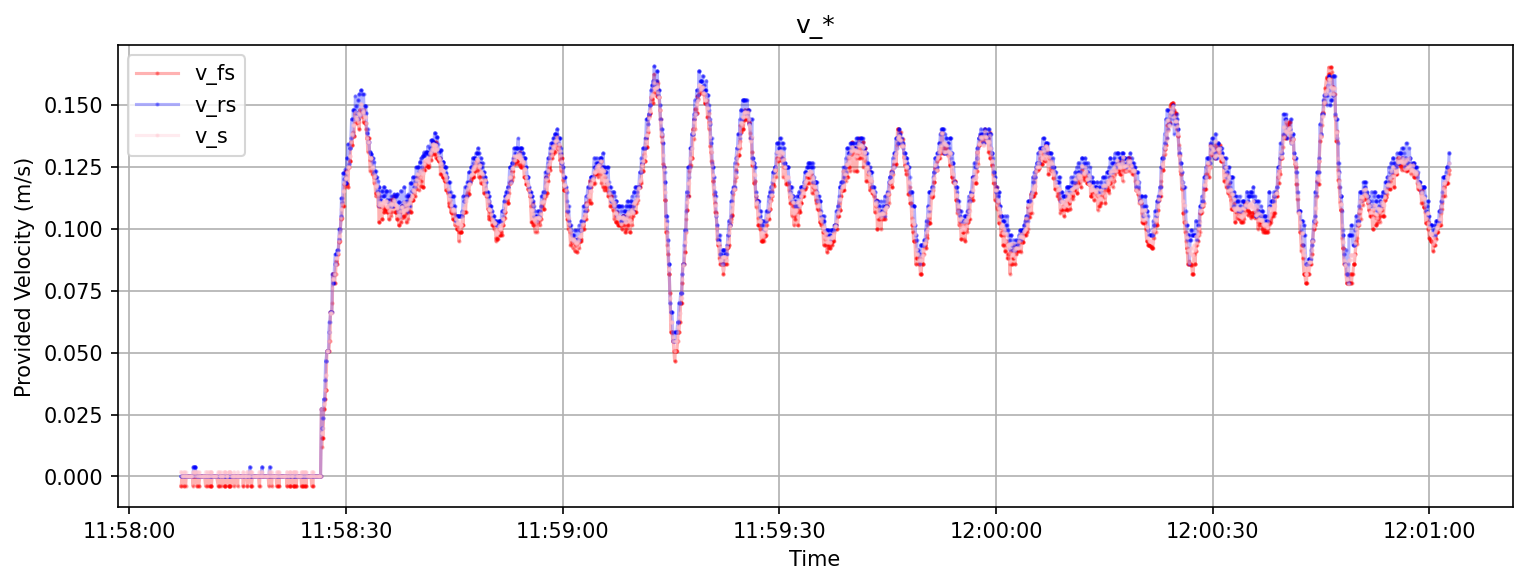

In [22]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("v_fs", "red"),
    ("v_rs", "blue"),
    ("v_s", "pink"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        ms=2,
        color=color,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="v_*",
    xlabel="Time",
    ylabel="Provided Velocity (m/s)",
)
ax.legend(loc="upper left")
ax.grid()

pass

## Computed RunDirection

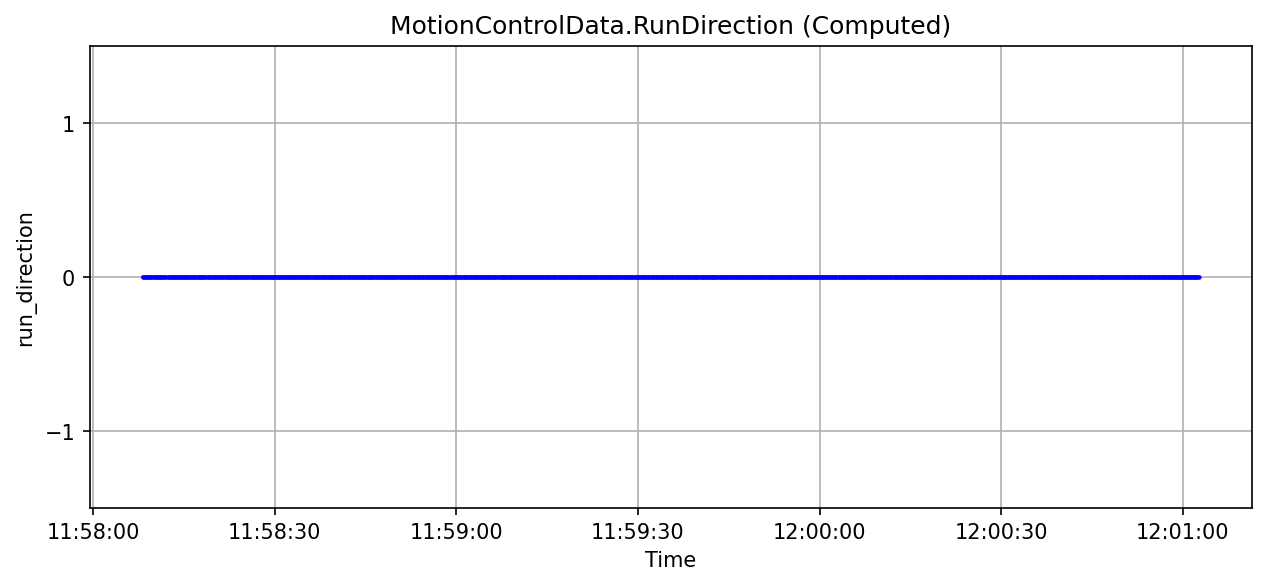

In [23]:
fig = plt.figure(figsize=(10, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["timestamp"], df["run_direction"], "b.-", ms=2, alpha=0.5)
ax.set(
    title="MotionControlData.RunDirection (Computed)",
    xlabel="Time",
    ylabel="run_direction",
    yticks=(-1, 0, 1),
    ylim=(-1.5, 1.5),
)
ax.grid()

pass

## Computed Offset

### Computed Offset Y

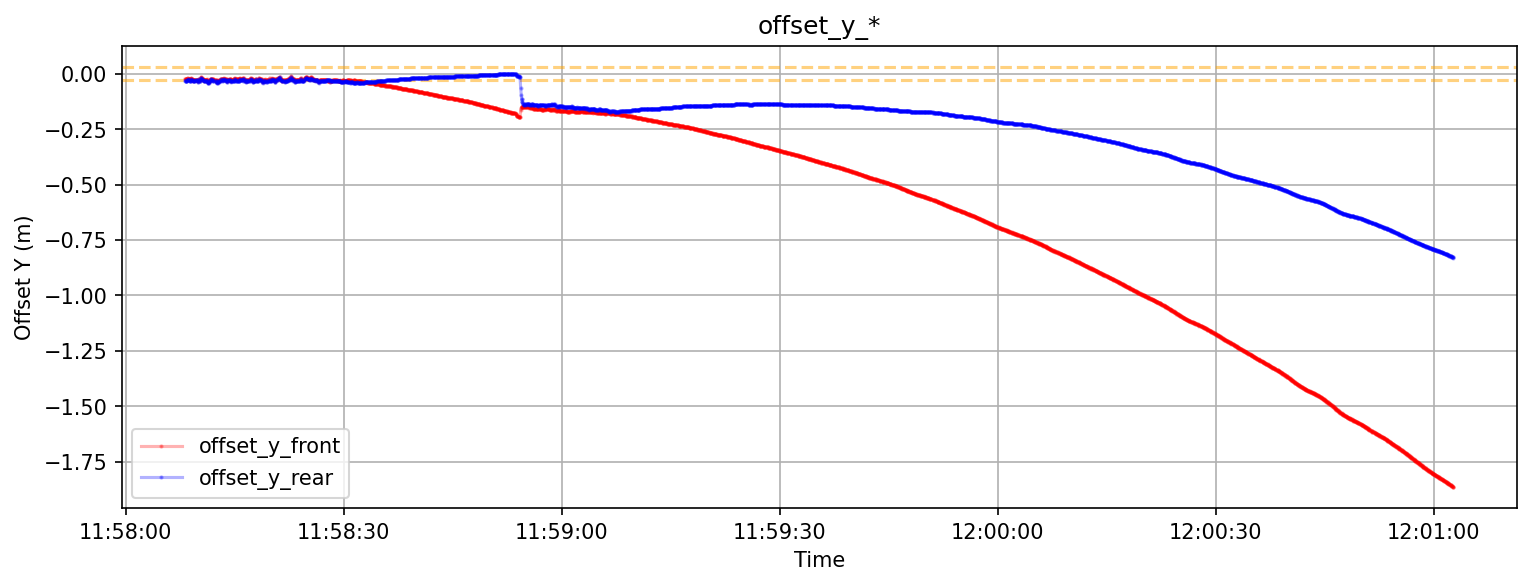

In [24]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.axhline(0.03, ls="--", color="orange", alpha=0.5)
ax.axhline(-0.03, ls="--", color="orange", alpha=0.5)

for label, color in (
    ("offset_y_front", "red"),
    ("offset_y_rear", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        color=color,
        ms=2,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="offset_y_*",
    xlabel="Time",
    ylabel="Offset Y (m)",
)
ax.legend()
ax.grid()

pass

### Computed Offset X

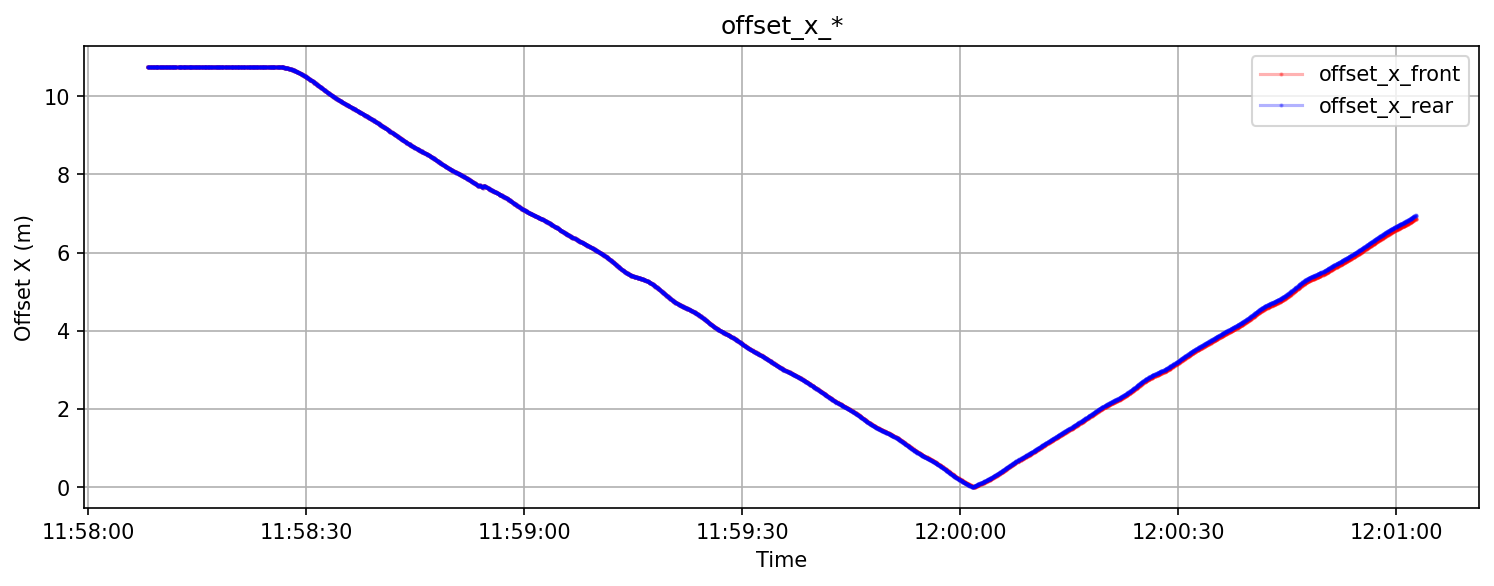

In [25]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("offset_x_front", "red"),
    ("offset_x_rear", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        color=color,
        ms=2,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="offset_x_*",
    xlabel="Time",
    ylabel="Offset X (m)",
)
ax.legend()
ax.grid()

pass

## Diff Angle to Target

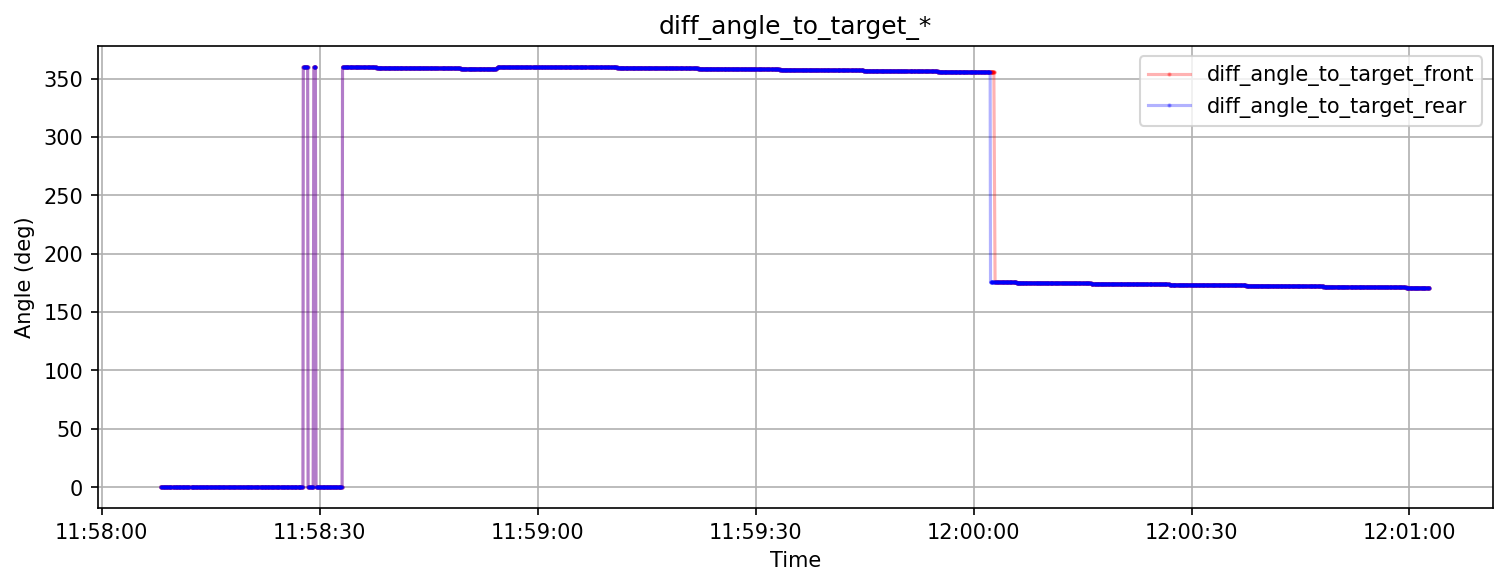

In [26]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("diff_angle_to_target_front", "red"),
    ("diff_angle_to_target_rear", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label] * 180 / pi,
        ".-",
        color=color,
        ms=2,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="diff_angle_to_target_*",
    xlabel="Time",
    ylabel="Angle (deg)",
)
ax.legend()
ax.grid()

pass

## PID Parameters

### $K_{\text{p}}$

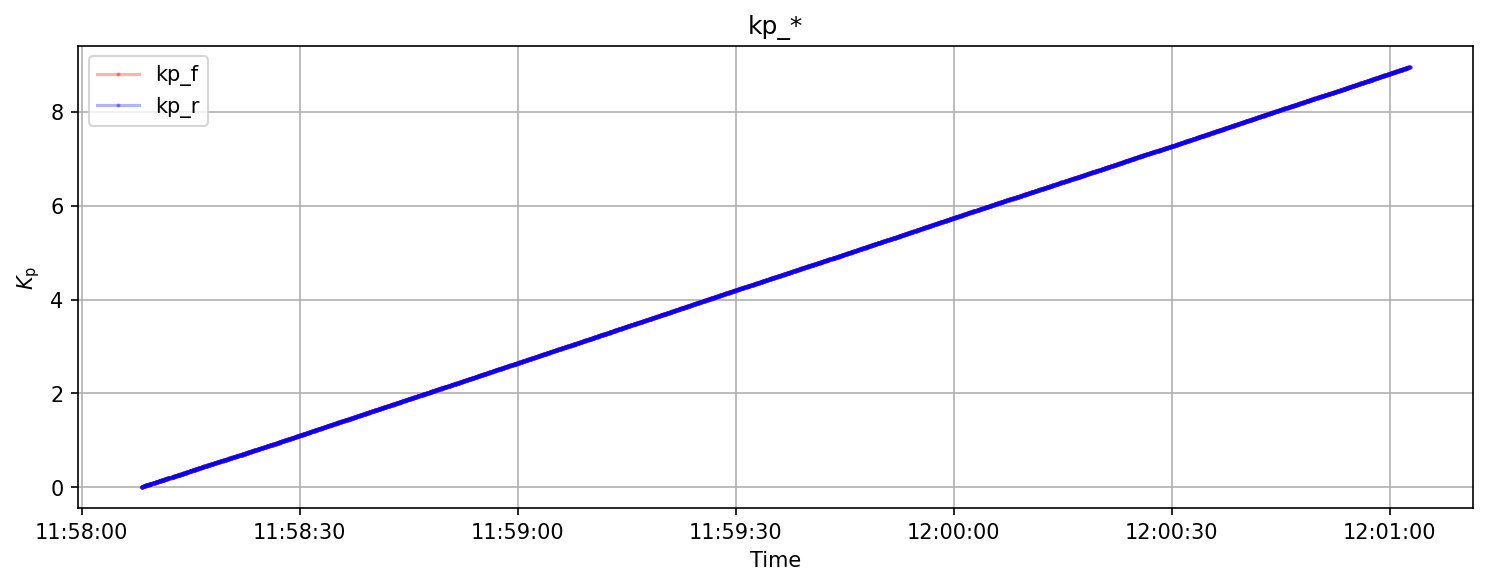

In [27]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("kp_f", "red"),
    ("kp_r", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        ms=2,
        color=color,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="kp_*",
    xlabel="Time",
    ylabel=R"$K_{\text{p}}$",
)
ax.legend()
ax.grid()

pass

### $K_{\text{i}}$

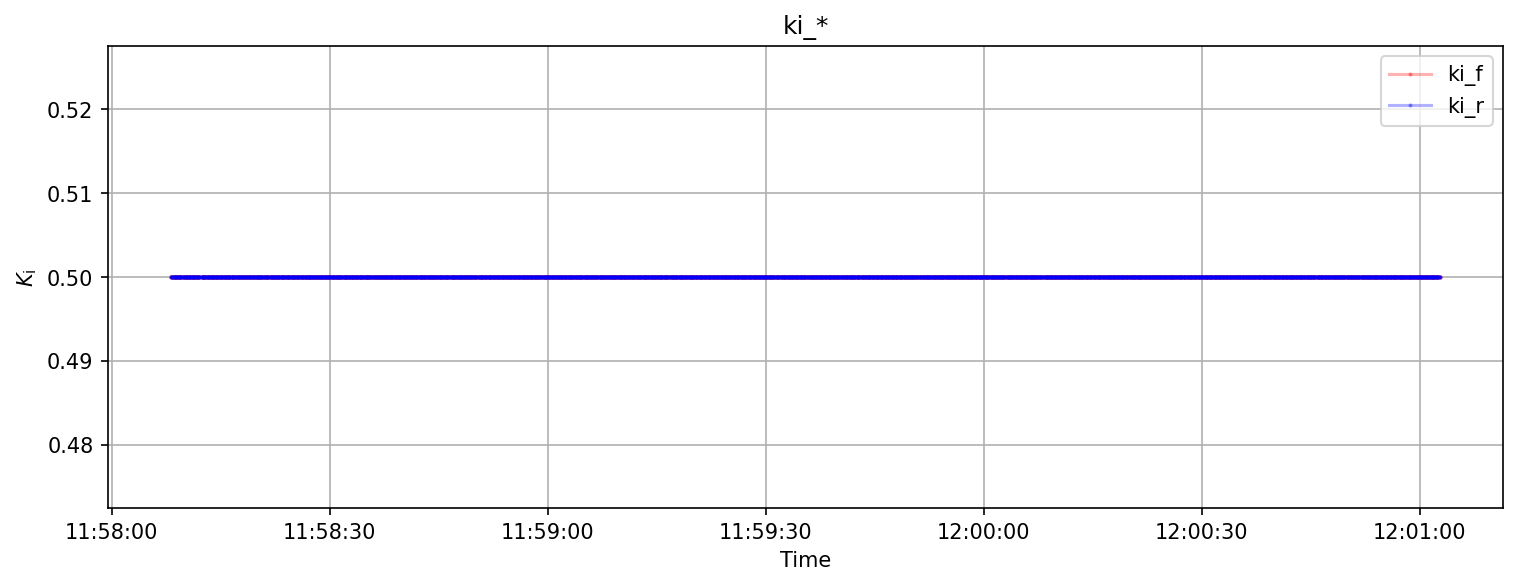

In [28]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("ki_f", "red"),
    ("ki_r", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        ms=2,
        color=color,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="ki_*",
    xlabel="Time",
    ylabel=R"$K_{\text{i}}$",
)
ax.legend()
ax.grid()

pass

### $K_{\text{d}}$

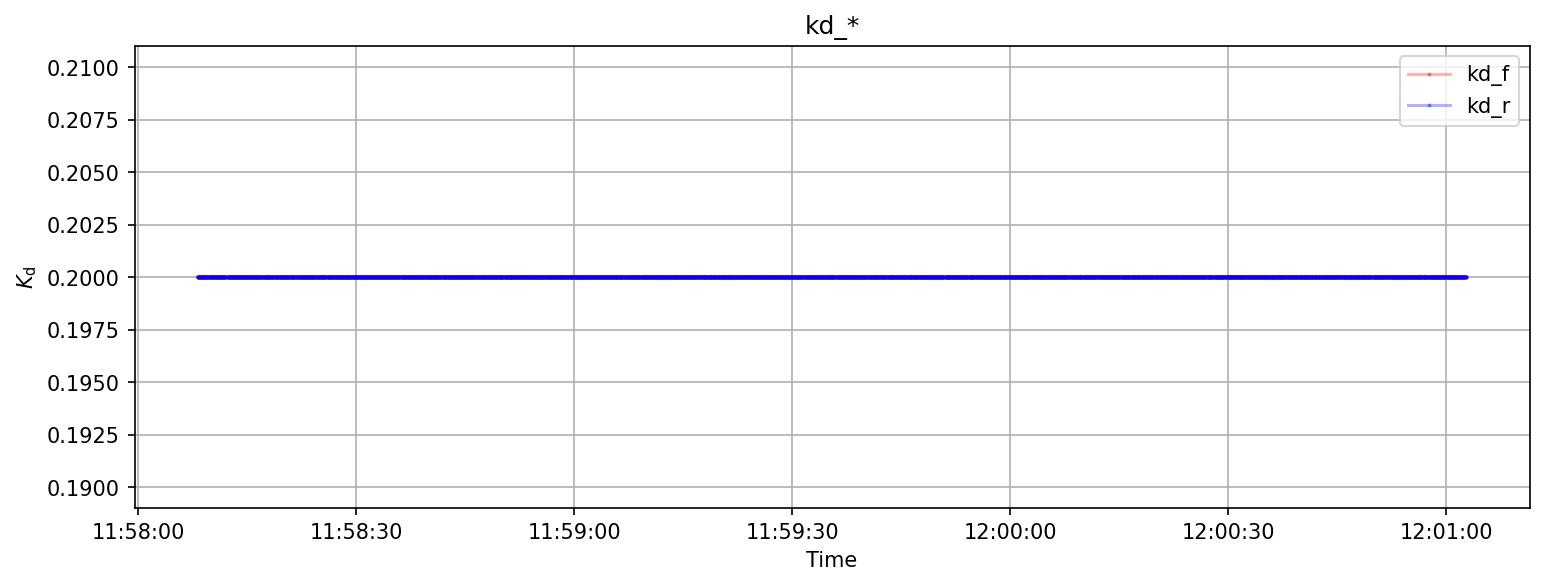

In [29]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("kd_f", "red"),
    ("kd_r", "blue"),
):
    ax.plot(
        df["timestamp"],
        df[label],
        ".-",
        ms=2,
        color=color,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="kd_*",
    xlabel="Time",
    ylabel=R"$K_{\text{d}}$",
)
ax.legend()
ax.grid()

pass

## PID Output (Cross Component)

In [30]:
if "vy_cross_f" in df:

    fig = plt.figure(figsize=(12, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()
    ax_twin = ax.twinx()

    for label, color, twin in (
        ("vy_cross_f_raw", "red", True),
        ("vy_cross_f", "orange", False),
        ("vy_cross_r_raw", "blue", True),
        ("vy_cross_r", "green", False),
    ):
        (ax_twin if twin else ax).plot(
            df["timestamp"],
            df[label],
            ".-",
            color=color,
            ms=2,
            alpha=0.3,
            label=label,
        )

    ax.set(
        title="vy_cross_* -- Cross Component Output from PID (before/after ValueLimit)",
        xlabel="Time",
        ylabel="After ValueLimit",
        # ylim=(-0.1, 0.1),
    )
    ax.legend(loc="center left")
    ax.grid(axis="y")

    ax_twin.set(
        ylabel="Before ValueLimit",
    )
    ax_twin.legend(loc="center right")

    pass

## PID Output (beta)

In [31]:
if "beta" in df:

    fig = plt.figure(figsize=(12, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()

    ax.plot(
        df["timestamp"],
        df["beta"] * 180 / pi,
        ".-",
        color="#19f",
        alpha=0.5,
    )

    ax.set(
        title="beta -- Angle Output from PID",
        xlabel="Time",
        ylabel="Angle (deg)",
    )
    ax.grid(axis="y")

    pass

## PID Output (SteerAngle_Feedback)

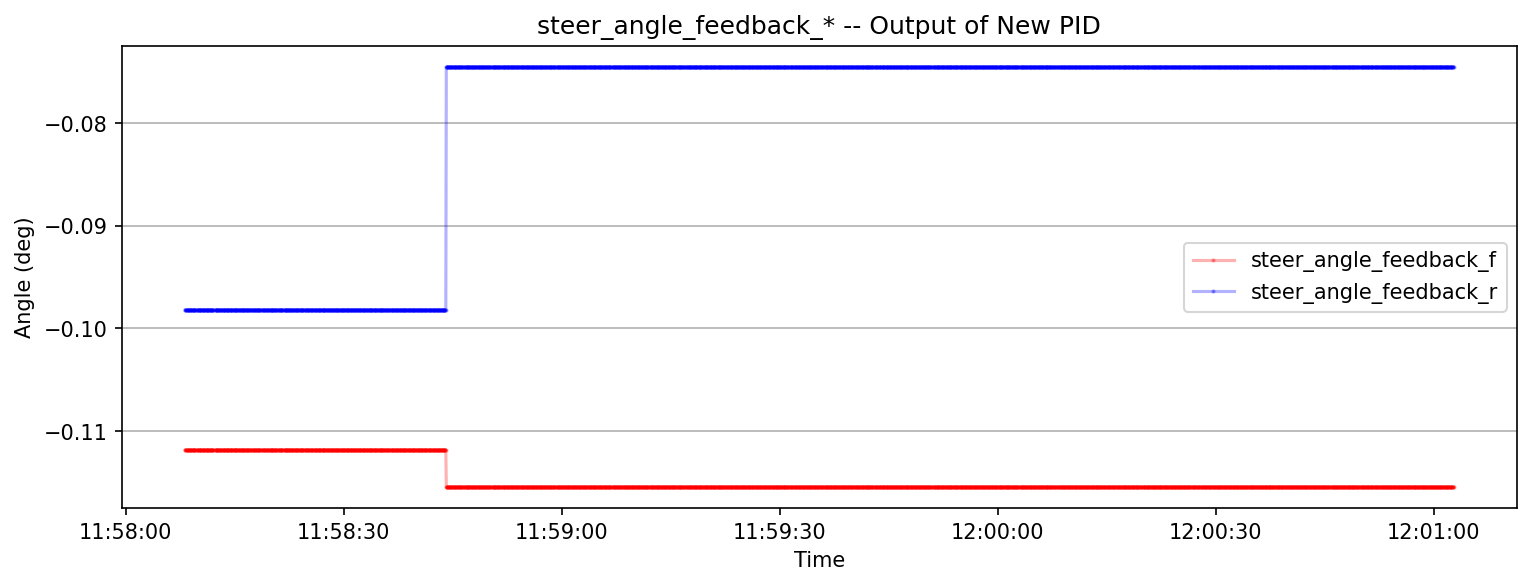

In [32]:
if "steer_angle_feedback_f" in df:

    fig = plt.figure(figsize=(12, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()

    for label, color in (
        ("steer_angle_feedback_f", "red"),
        ("steer_angle_feedback_r", "blue"),
    ):
        ax.plot(
            df["timestamp"],
            df[label] * 180 / pi,
            ".-",
            color=color,
            ms=2,
            alpha=0.3,
            label=label,
        )

    ax.set(
        title="steer_angle_feedback_* -- Output of New PID",
        xlabel="Time",
        ylabel="Angle (deg)",
        # ylim=(-8, 8),
    )
    ax.legend()
    ax.grid(axis="y")

    pass

## PID Output (SteerAngle)

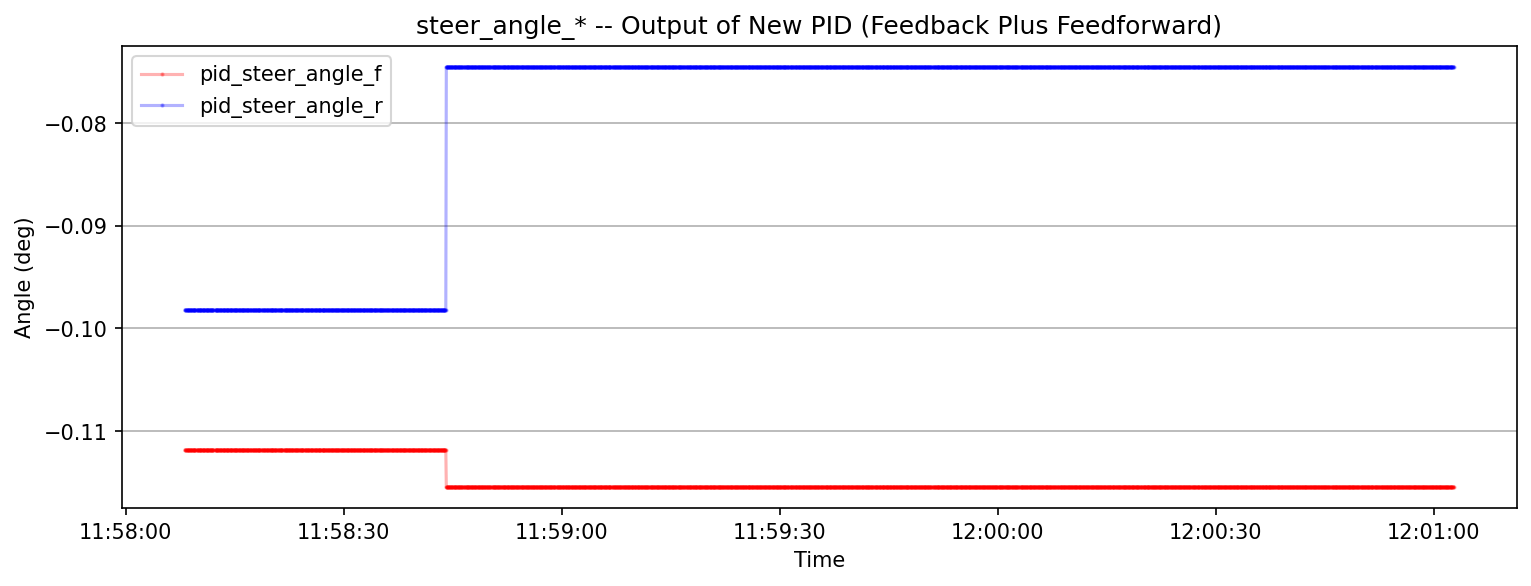

In [33]:
if "pid_steer_angle_f" in df:

    fig = plt.figure(figsize=(12, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()

    for label, color in (
        ("pid_steer_angle_f", "red"),
        ("pid_steer_angle_r", "blue"),
    ):
        ax.plot(
            df["timestamp"],
            df[label] * 180 / pi,
            ".-",
            color=color,
            ms=2,
            alpha=0.3,
            label=label,
        )

    ax.set(
        title="steer_angle_* -- Output of New PID (Feedback Plus Feedforward)",
        xlabel="Time",
        ylabel="Angle (deg)",
        # ylim=(-8, 8),
    )
    ax.legend()
    ax.grid(axis="y")

    pass

## Arrival Flag

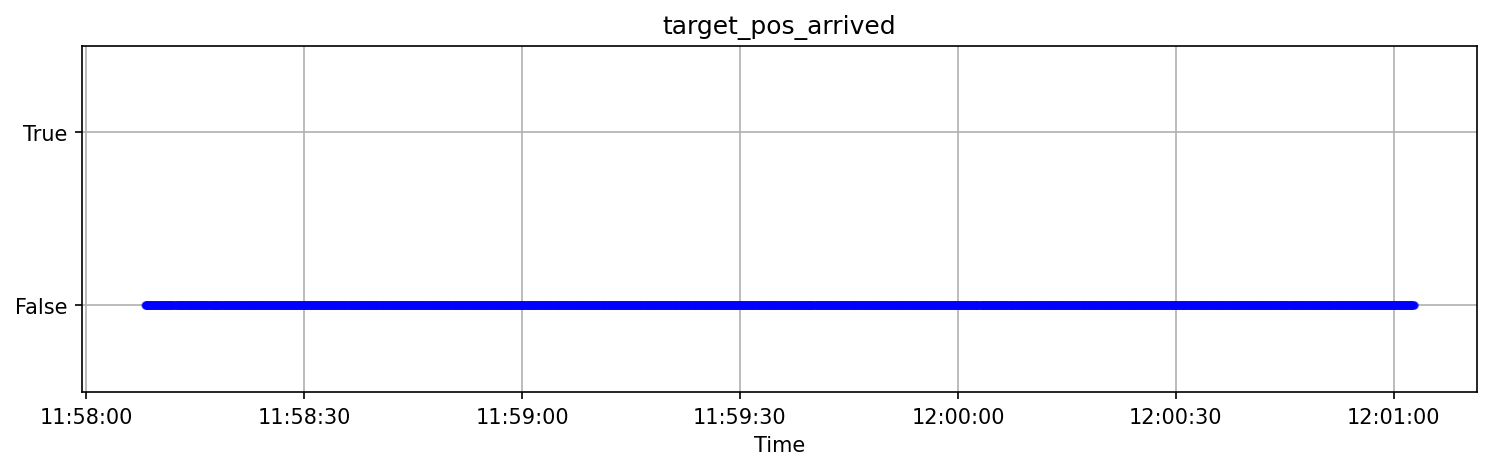

In [34]:
fig = plt.figure(figsize=(12, 3), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["timestamp"], df["target_pos_arrived"], "b.-", alpha=0.5)
ax.set(
    title="target_pos_arrived",
    xlabel="Time",
    yticks=(0, 1),
    yticklabels=("False", "True"),
    ylim=(-0.5, 1.5),
)
ax.grid()

pass

### Front Position After Arrival Flag

In [35]:
if (df["target_pos_arrived"] != 1).all():
    first_arrival_index = -1
    print("not arrived")
else:

    first_arrival_index = df[df["target_pos_arrived"] == 1].index[0]
    print(first_arrival_index)
    print(df.loc[first_arrival_index, "timestamp"])
    print(df.loc[first_arrival_index, "x_front"])
    print(df.loc[first_arrival_index, "y_front"])

    fig = plt.figure(figsize=(10, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()
    ax_twin = ax.twinx()

    line_1 = ax.plot(
        df["timestamp"].loc[first_arrival_index:],
        df["x_front"].loc[first_arrival_index:],
        "b.-",
        ms=2,
        alpha=0.5,
        label="x_front",
    )[0]
    line_2 = ax_twin.plot(
        df["timestamp"].loc[first_arrival_index:],
        df["y_front"].loc[first_arrival_index:],
        "r.-",
        ms=2,
        alpha=0.5,
        label="y_front",
    )[0]

    ax.set(
        title="Front Antenna Position After Arrival Detected",
        xlabel="Time",
        ylabel="x (m)",
    )
    ax_twin.set_ylabel("y (m)")
    ax.legend(handles=(line_1, line_2), loc="center right")
    ax.grid()

    ax_twin.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    pass

not arrived


### Front Speed After Arrival Flag

In [36]:
if (df["target_pos_arrived"] != 1).all():
    first_arrival_index = -1
    print("not arrived")
else:

    first_arrival_index = df[df["target_pos_arrived"] == 1].index[0]
    print(first_arrival_index)
    print(df.loc[first_arrival_index, "timestamp"])
    print(
        df.loc[first_arrival_index, "command_speed_fs_rpm"]
        / 60 * 2 * pi * WHEEL_RADIUS / 23.5
    )

    fig = plt.figure(figsize=(10, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()

    line_1 = ax.plot(
        df["timestamp"].loc[first_arrival_index:],
        (
            df["command_speed_fs_rpm"].loc[first_arrival_index:]
            / 60 * 2 * pi * WHEEL_RADIUS / 23.5
        ),
        "b.-",
        ms=2,
        alpha=0.5,
        label="command_speed_fs_rpm",
    )[0]
    line_2 = ax.plot(
        df["timestamp"].loc[first_arrival_index:],
        (
            df["command_speed_rs_rpm"].loc[first_arrival_index:]
            / 60 * 2 * pi * WHEEL_RADIUS / 23.5
        ),
        "r.-",
        ms=2,
        alpha=0.5,
        label="command_speed_rs_rpm",
    )[0]

    ax.set(
        title="Front Antenna Speed After Arrival Detected",
        xlabel="Time",
        ylabel="Speed (m/s)",
    )
    ax.legend(handles=(line_1, line_2), loc="center right")
    ax.grid()

    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    pass

not arrived


## Set Points

### Command Angles

command_steer_angle_fl ∈ [-0.1, 0.0]
command_steer_angle_fr ∈ [-0.1, 0.0]
command_steer_angle_rl ∈ [0.0, 0.0]
command_steer_angle_rr ∈ [0.0, 0.0]
command_steer_angle_fs ∈ [-0.1, -0.1]
command_steer_angle_rs ∈ [0.0, 0.0]


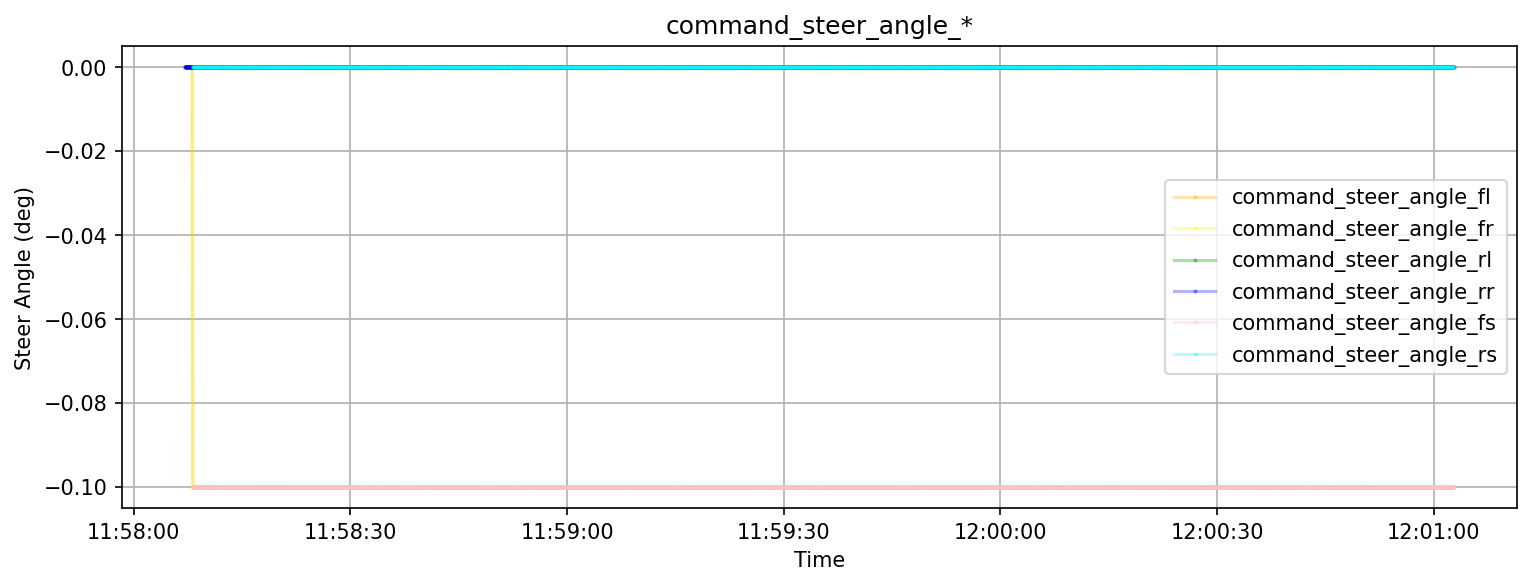

In [37]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("command_steer_angle_fl", "orange"),
    ("command_steer_angle_fr", "yellow"),
    ("command_steer_angle_rl", "green"),
    ("command_steer_angle_rr", "blue"),
    ("command_steer_angle_fs", "pink"),
    ("command_steer_angle_rs", "cyan"),
):
    v = df[label] / 10
    # v = v[1600:1800]
    print(f"{label} ∈ [{v.min():.1f}, {v.max():.1f}]")
    ax.plot(
        df["timestamp"],
        v,
        ".-",
        ms=2,
        color=color,
        alpha=0.3,
        label=label,
    )

ax.set(
    title="command_steer_angle_*",
    xlabel="Time",
    ylabel="Steer Angle (deg)",
)
ax.legend()
ax.grid()

pass

### Command Speed

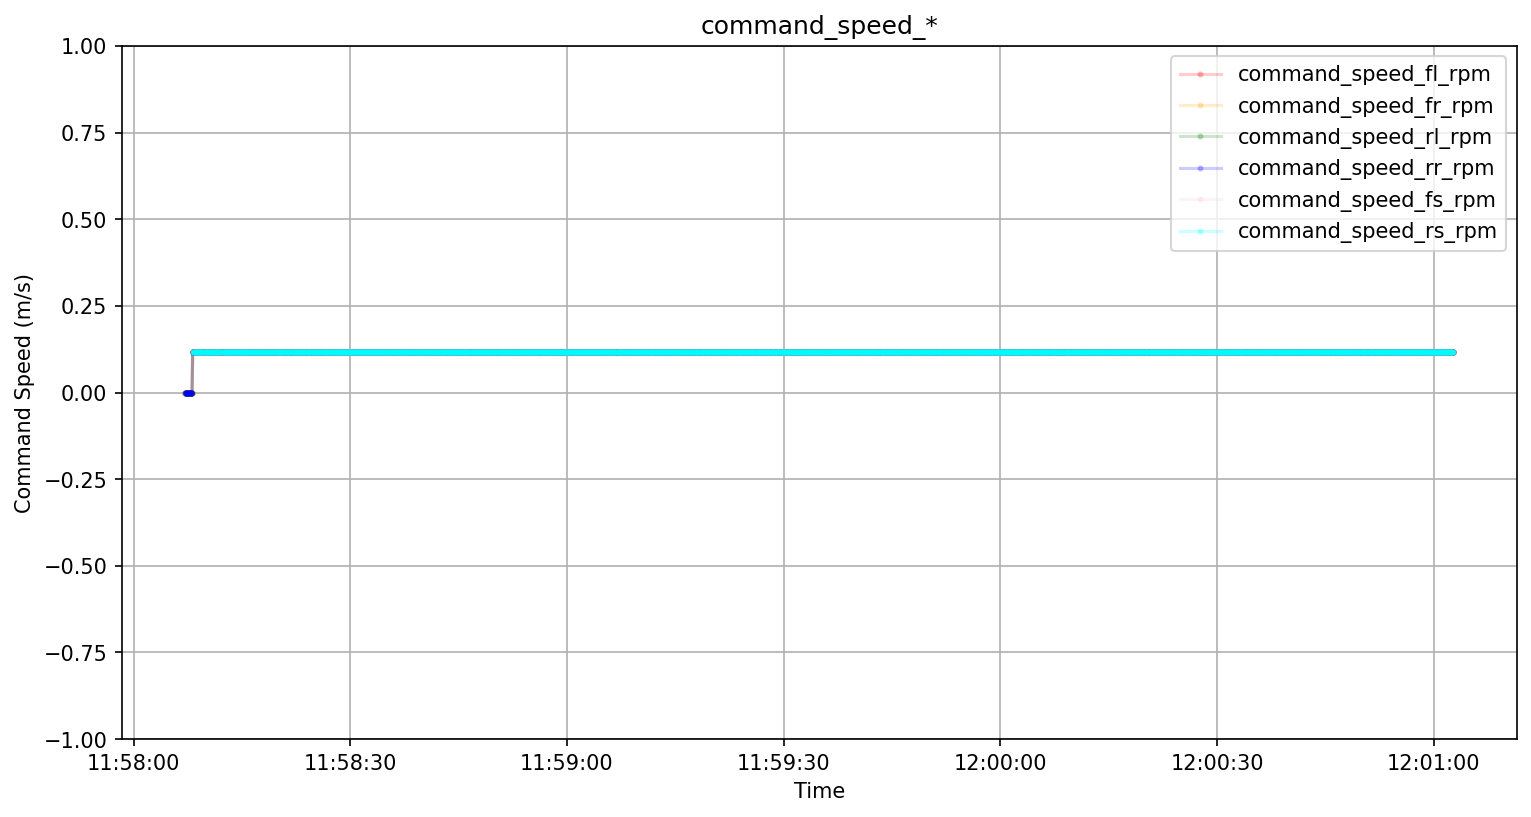

In [38]:
fig = plt.figure(figsize=(12, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

for label, color in (
    ("command_speed_fl_rpm", "red"),
    ("command_speed_fr_rpm", "orange"),
    ("command_speed_rl_rpm", "green"),
    ("command_speed_rr_rpm", "blue"),
    ("command_speed_fs_rpm", "pink"),
    ("command_speed_rs_rpm", "cyan"),
):
    ax.plot(
        df["timestamp"],
        df[label] / 60 * 2 * pi * WHEEL_RADIUS / 23.5,
        "o-",
        color=color,
        alpha=0.2,
        label=label,
        ms=2,
    )

ax.set(
    title="command_speed_*",
    xlabel="Time",
    ylabel="Command Speed (m/s)",
    ylim=(-1, 1),
)
ax.legend()
ax.grid()

pass

### Brake Command

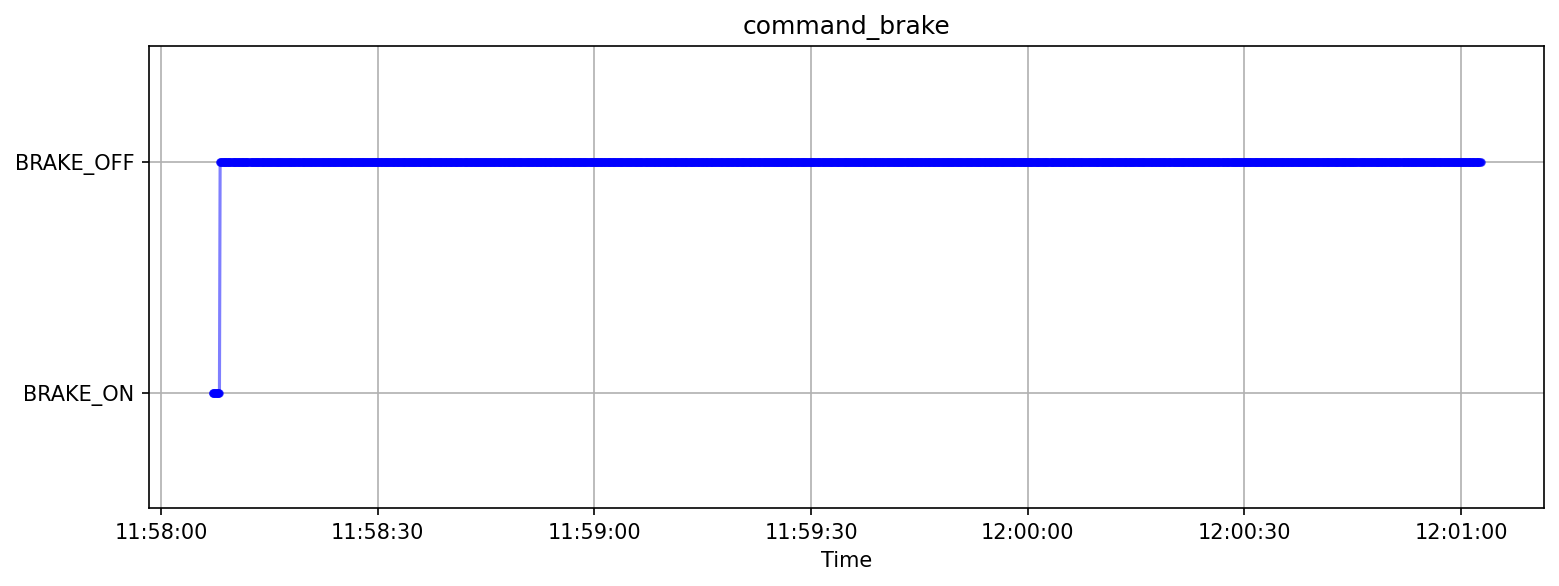

In [39]:
fig = plt.figure(figsize=(12, 4), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(df["timestamp"], df["command_brake"], "b.-", alpha=0.5)
ax.set(
    title="command_brake",
    xlabel="Time",
    ylim=(-0.5, 1.5),
    yticks=(0, 1),
    yticklabels=("BRAKE_ON", "BRAKE_OFF"),
)
ax.grid()

pass

### Brake Point

In [40]:
if first_arrival_index >= 0:
    first_brake_index = (
        df.iloc[(len(df) // 2):].loc[df["command_brake"] == 0].index[0]
    )
    print(first_brake_index)
    print(df.loc[first_brake_index, "timestamp"])
    print(df.loc[first_brake_index, "x_front"])
    print(df.loc[first_brake_index, "y_front"])

#### Front Antenna Position After Brake Command

In [41]:
if first_arrival_index >= 0:

    fig = plt.figure(figsize=(10, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()
    ax_twin = ax.twinx()

    line_1 = ax.plot(
        df["timestamp"].loc[first_brake_index:],
        df["x_front"].loc[first_brake_index:],
        "b.-",
        ms=2,
        alpha=0.5,
        label="x_front",
    )[0]
    line_2 = ax_twin.plot(
        df["timestamp"].loc[first_brake_index:],
        df["y_front"].loc[first_brake_index:],
        "r.-",
        ms=2,
        alpha=0.5,
        label="y_front",
    )[0]
    ax.set(
        title="Front Antenna Position After Brake Point",
        xlabel="Time",
        ylabel="x (m)",
    )
    ax_twin.set_ylabel("y (m)")
    ax.legend(handles=(line_1, line_2), loc="upper center")
    ax.grid()

    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax_twin.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    pass

#### Front Speed After Brake Command

In [42]:
if first_arrival_index >= 0:

    fig = plt.figure(figsize=(12, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()

    for label, color in (
        ("command_speed_fl_rpm", "red"),
        ("command_speed_fr_rpm", "orange"),
        ("v_fl", "green"),
        ("v_fr", "blue"),
    ):
        s_speed = df[label].loc[first_brake_index:]
        if label.endswith("_rpm"):
            s_speed = s_speed / 60 * 2 * pi * WHEEL_RADIUS / 23.5
        ax.plot(
            df["timestamp"].loc[first_brake_index:],
            s_speed,
            ".-",
            color=color,
            alpha=0.3,
            label=label,
        )

    ax.set(
        title="Speed After Brake Point",
        xlabel="Time",
        ylabel="Speed (m/s)",
    )
    ax.legend()
    ax.grid()

    pass

#### Rel X/Y After Brake Command

In [43]:
if first_arrival_index >= 0:

    fig = plt.figure(figsize=(10, 4), dpi=150)
    fig.set_facecolor("#fff")
    ax = fig.add_subplot()
    ax_twin = ax.twinx()

    line_1 = ax.plot(
        df["timestamp"].loc[first_brake_index:],
        df["rel_x_f"].loc[first_brake_index:],
        "r.-",
        ms=2,
        alpha=0.5,
        label="rel_x_f",
    )[0]
    line_2 = ax_twin.plot(
        df["timestamp"].loc[first_brake_index:],
        df["rel_y_f"].loc[first_brake_index:],
        "b.-",
        ms=2,
        alpha=0.5,
        label="rel_y_f",
    )[0]
    line_3 = ax.plot(
        df["timestamp"].loc[first_brake_index:],
        df["rel_x_r"].loc[first_brake_index:],
        "g.-",
        ms=2,
        alpha=0.5,
        label="rel_x_r",
    )[0]
    line_4 = ax_twin.plot(
        df["timestamp"].loc[first_brake_index:],
        df["rel_y_r"].loc[first_brake_index:],
        "c.-",
        ms=2,
        alpha=0.5,
        label="rel_y_r",
    )[0]

    ax.set(
        title="Rel X/Y After Brake Point",
        xlabel="Time",
        ylabel="x (m)",
    )
    ax_twin.set_ylabel("y (m)")
    ax.legend(handles=(line_1, line_2, line_3, line_4))
    ax.grid()

    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    pass